In [154]:
from typing import List, Dict, Any, Optional, Tuple, Set, Callable
import requests
import math
from enum import Enum
import os
from collections import defaultdict
import json
import time
from datetime import datetime, timedelta, timezone
import random
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [155]:
VERSION = "v2.0"
DATASET = "test"   # train or test

## Data loading

In [156]:
CSV_PATH: str = "C:/P/backend/LambdaPY/graph_manager/builder_service/local/csv_test"

In [157]:
orders_df = pd.read_csv(f"{CSV_PATH}/order_{DATASET}.csv")
orders_df.tail()

,id,manufacturer_id,manufacturer_order_id,site_id,carrier_id,status,n_steps,tracking_link,tracking_number,manufacturer_creation_timestamp,manufacturer_estimated_delivery_timestamp,manufacturer_confirmed_delivery_timestamp,carrier_creation_timestamp,carrier_estimated_delivery_timestamp,carrier_confirmed_delivery_timestamp,SLS,SRS
5,54,1,7357,3,2,DELIVERED,12,https://www.ups.com/track?tracknum=1ZR46591041...,1ZR465910413316617,2025-05-09 11:10:00+00:00,2025-05-12 20:00:00+00:00,2025-05-16 04:47:00+00:00,2025-05-09 19:07:00+00:00,NaN,2025-05-12 13:21:00+00:00,0,0
6,100,1,8108,3,2,DELIVERED,12,https://www.ups.com/track?tracknum=1ZR46591041...,1ZR465910413368928,2025-07-11 13:39:00+00:00,2025-07-14 20:00:00+00:00,2025-07-15 08:04:00+00:00,2025-07-11 21:54:00+00:00,NaN,2025-07-15 14:59:00+00:00,0,0
7,12,1,6121,4,3,DELIVERED,12,https://www.fedex.com/fedextrack/?trknbr=43925...,439256767958,2025-01-23 15:59:00+00:00,2025-01-27 22:00:00+00:00,2025-01-28 11:58:00+00:00,2025-01-24 23:07:00+00:00,NaN,2025-01-28 11:50:00+00:00,0,0
8,60,1,7429,3,2,DELIVERED,12,https://www.ups.com/track?tracknum=1ZR46591041...,1ZR465910413322468,2025-05-16 10:01:00+00:00,2025-05-19 20:00:00+00:00,2025-05-20 06:04:00+00:00,2025-05-16 20:27:00+00:00,NaN,2025-05-19 14:28:00+00:00,0,0
9,93,1,7942,3,2,DELIVERED,11,https://www.ups.com/track?tracknum=1ZR46591041...,1ZR465910413361729,2025-07-01 10:41:00+00:00,2025-07-03 20:00:00+00:00,2025-07-15 07:08:00+00:00,2025-07-02 23:27:00+00:00,NaN,2025-07-10 13:43:00+00:00,0,0


In [158]:
order_steps_enriched_df = pd.read_csv(f"{CSV_PATH}/order_steps_enriched_{DATASET}.csv")
order_steps_enriched_df.head()

,order_id,step_source,timestamp_source,location_source,step_destination,timestamp_destination,location_destination,hours,geodesic_km
0,12,1,2025-01-24 23:07:00+00:00,"GRAND PRAIRIE, TEXAS, US",2,2025-01-24 23:07:00+00:00,"GRAND PRAIRIE, TEXAS, US",0.000000,0.000000
1,12,2,2025-01-24 23:07:00+00:00,"GRAND PRAIRIE, TEXAS, US",3,2025-01-24 23:40:00+00:00,"MANSFIELD, TEXAS, US",0.550000,24.353223
2,12,3,2025-01-24 23:40:00+00:00,"MANSFIELD, TEXAS, US",4,2025-01-25 04:30:00+00:00,"NEW YORK, NEW YORK, US",4.833333,2249.220628
3,12,4,2025-01-25 04:30:00+00:00,"NEW YORK, NEW YORK, US",5,2025-01-25 11:17:00+00:00,"NEW YORK, NEW YORK, US",6.783333,0.000000
4,12,5,2025-01-25 11:17:00+00:00,"NEW YORK, NEW YORK, US",6,2025-01-25 19:06:00+00:00,"PARIS, ÎLE-DE-FRANCE, FR",7.816667,5852.736948


In [159]:
sites_df = pd.read_csv(f"{CSV_PATH}/site.csv")
sites_df.head()

,id,supplier_id,location_name,n_rejections,n_orders,consider_closure_holidays,consider_working_holidays,consider_weekends_holidays
0,1,1,"LEEDS, ENGLAND, GB",0,5,True,True,True
1,2,2,"LOUISVILLE, KENTUCKY, US",0,3,True,True,True
2,3,2,"THIEF RIVER FALLS, MINNESOTA, US",0,61,True,True,True
3,4,3,"GRAND PRAIRIE, TEXAS, US",0,5,True,True,True
4,5,4,"MONTAGNOLA, TICINO, CH",0,1,True,True,True


In [160]:
suppliers_df = pd.read_csv(f"{CSV_PATH}/supplier.csv")
suppliers_df.head()

,id,manufacturer_supplier_id,name
0,1,1,FARNELL
1,2,2,DIGIKEY
2,3,3,MOUSER
3,4,4,AUTO SUPPLY
4,5,8,SAFE


In [161]:
carriers_df = pd.read_csv(f"{CSV_PATH}/carrier.csv")
carriers_df.head()

,id,name,carrier_17track_id,n_losses,n_orders
0,1,DHL Express,100001,0,5
1,2,UPS,100002,0,72
2,3,FedEx,100003,0,13
3,4,DHL,100004,0,16
4,5,DPD,100005,0,0


In [162]:
manufacturers_df = pd.read_csv(f"{CSV_PATH}/manufacturer.csv")
manufacturers_df.head()

,id,location_name,name
0,1,"GAZZANIGA, LOMBARDY, IT",FAE


## Estimation

### URLs

In [163]:
API_URL = "https://rhwompporf.execute-api.eu-central-1.amazonaws.com/dev"
ROOT_URL = f"{API_URL}/"

WARMING_URL = f"{ROOT_URL}lcdi/realtime/"
ESTIMATION_URL = f"{ROOT_URL}lcdi/realtime/volatile"
DB_URL = f"{ROOT_URL}db"

DB_URL, ESTIMATION_URL, WARMING_URL

('https://rhwompporf.execute-api.eu-central-1.amazonaws.com/dev/db',
 'https://rhwompporf.execute-api.eu-central-1.amazonaws.com/dev/lcdi/realtime/volatile',
 'https://rhwompporf.execute-api.eu-central-1.amazonaws.com/dev/lcdi/realtime/')

### Utility functions

In [164]:
PT_CONFIDENCE_ID: int = 36

def update_pt_confidence(confidence: float, pt_confidence_param_id: int = PT_CONFIDENCE_ID) -> Dict[str, Any]:
    assert 0 < confidence < 1
    response = requests.put(f"{DB_URL}/tables/params/{pt_confidence_param_id}", 
                            json={
                                "data": {
                                    "name": "PT_CONFIDENCE",
                                    "general_category": "REALTIME",
                                    "category": "PT",
                                    "description": "Path time confidence (beta 2 parameter for TFST indicator)",
                                    "value": confidence
                                    }
                                })
    response.raise_for_status()
    return response.json()

update_pt_confidence(0.5)

{'success': True,
 'message': 'Record updated successfully',
 'data': {'id': 36,
  'created_at': '2025-07-29T07:14:05.260Z',
  'updated_at': '2025-08-30T08:30:07.504Z',
  'name': 'PT_CONFIDENCE',
  'general_category': 'REALTIME',
  'category': 'PT',
  'description': 'Path time confidence (beta 2 parameter for TFST indicator)',
  'value': '0.500000'},
 'meta': {'recordsAffected': 1, 'executionTime': 280},
 'timestamp': '2025-08-30T08:30:07.521Z'}

In [165]:
TT_CONFIDENCE_ID: int = 37

def update_tt_confidence(confidence: float, tt_confidence_param_id: int = TT_CONFIDENCE_ID) -> Dict[str, Any]:
    assert 0 < confidence < 1
    response = requests.put(f"{DB_URL}/tables/params/{tt_confidence_param_id}", 
                            json={
                                "data": {
                                    "name": "TT_CONFIDENCE",
                                    "general_category": "REALTIME",
                                    "category": "TT",
                                    "description": "Transit time confidence (beta 1 parameter for TFST indicator)",
                                    "value": confidence
                                    }
                                })
    response.raise_for_status()
    return response.json()

update_tt_confidence(0.5)

{'success': True,
 'message': 'Record updated successfully',
 'data': {'id': 37,
  'created_at': '2025-07-29T07:14:05.260Z',
  'updated_at': '2025-08-30T08:30:07.861Z',
  'name': 'TT_CONFIDENCE',
  'general_category': 'REALTIME',
  'category': 'TT',
  'description': 'Transit time confidence (beta 1 parameter for TFST indicator)',
  'value': '0.500000'},
 'meta': {'recordsAffected': 1, 'executionTime': 248},
 'timestamp': '2025-08-30T08:30:07.866Z'}

### Requests body construction

In [166]:
def require_estimation(url: str, data: Dict[str, Any] | List[Dict[str, Any]]) -> List[Dict[str, Any]] | Dict[str, Any]:
    """
    Make a POST request to the estimation API.
    """
    response = requests.post(url=url, json=data)
    response.raise_for_status()
    return response.json()

In [167]:
def create_estimation_request_body(
    vertex_name: str,
    vertex_type: str,
    site_id: int,
    carrier_id: int,
    order_time: datetime,
    event_time: datetime,
    estimation_time: datetime,
    maybe_shipment_time: Optional[datetime] = None,
) -> Dict[str, Any]:

    return {
        "vertex": {
            "vertexName": vertex_name,
            "vertexType": vertex_type,
        },
        "carrier": {
            "carrierId": carrier_id,
        },
        "site": {
            "siteId": site_id,
        },
        "orderTime": order_time.isoformat(),
        "shipmentTime": maybe_shipment_time.isoformat() if maybe_shipment_time else None,
        "eventTime": event_time.isoformat(),
        "estimationTime": estimation_time.isoformat(),
    }

In [168]:
manufacturer_name: str = manufacturers_df.iloc[0]["name"]
manufacturer_name

'FAE'

In [169]:
requests_dispatch_body: List[Dict[str, Any]] = []
dispatch_order_ids: List[int] = []

requests_shipment_body: List[Dict[str, Any]] = []
shipment_order_ids: List[int] = []

requests_delivery_body: List[Dict[str, Any]] = []
delivery_order_ids: List[int] = []

bad_orders_ids: Set[int] = set()

for i, row in order_steps_enriched_df.iterrows():
    order_row: pd.Series = orders_df[orders_df["id"] == row["order_id"]].iloc[0]
    order_id: int = order_row["id"]

    site_id: int = int(order_row["site_id"])
    carrier_id: int = int(order_row["carrier_id"])

    order_time: datetime = pd.to_datetime(order_row["manufacturer_creation_timestamp"])
    shipment_time: datetime = pd.to_datetime(order_row["carrier_creation_timestamp"])
    delivery_time: datetime = pd.to_datetime(order_row['carrier_confirmed_delivery_timestamp'])

    step_source: int = row["step_source"]
    step_destination: int = row["step_destination"]

    event_time: datetime = pd.to_datetime(row["timestamp_source"])
    estimation_time: datetime = event_time

    if not order_time <= shipment_time <= event_time <= estimation_time:
        print(f"Order ID {order_id} has invalid times: "
              f"order_time={order_time}, shipment_time={shipment_time}, "
              f"event_time={event_time}, estimation_time={estimation_time}")
        bad_orders_ids.add(order_id)
        continue

    if step_source == 1:
        vertex_name: str = str(site_id)
        vertex_type: str = "SUPPLIER_SITE"
        requests_dispatch_body.append(create_estimation_request_body(            # Estimation for when the order is still in dispatch
            vertex_name=vertex_name,
            vertex_type=vertex_type,
            site_id=site_id,
            carrier_id=carrier_id,
            order_time=order_time,
            event_time=order_time,
            estimation_time=order_time
        ))
        dispatch_order_ids.append(int(order_id))
    else:
        vertex_name: str = row["location_source"]
        vertex_type: str = "INTERMEDIATE"
        
    request_body: Dict[str, Any] = create_estimation_request_body(      # Estimation for the carrier event
        vertex_name=vertex_name,
        vertex_type=vertex_type,
        site_id=site_id,
        carrier_id=carrier_id,
        order_time=order_time,
        maybe_shipment_time=shipment_time,
        event_time=event_time,
        estimation_time=estimation_time,
    )
    requests_shipment_body.append(request_body)
    shipment_order_ids.append(int(order_id))

    if step_destination == order_row["n_steps"]:
        requests_delivery_body.append(create_estimation_request_body(            # Estimation for the last event (delivery to the manufacturer)
            vertex_name=manufacturer_name,
            vertex_type="MANUFACTURER",
            site_id=site_id,
            carrier_id=carrier_id,
            order_time=order_time,
            maybe_shipment_time=shipment_time,
            event_time=pd.to_datetime(row['timestamp_destination']),
            estimation_time=pd.to_datetime(row['timestamp_destination']),
        ))
        delivery_order_ids.append(int(order_id))

len(requests_dispatch_body), len(requests_shipment_body), len(requests_delivery_body)

(10, 106, 10)

In [170]:
bad_orders_ids_steps_df = order_steps_enriched_df[order_steps_enriched_df["order_id"].isin(bad_orders_ids)]
assert len(requests_dispatch_body) + len(requests_shipment_body) + len(requests_delivery_body) == len(order_steps_enriched_df) + 2 * len(orders_df) - (len(bad_orders_ids_steps_df) + 2 * len(bad_orders_ids))

### Estimation computation

In [171]:
def chunked(iterable: List, size: int):
    for i in range(0, len(iterable), size):
        yield iterable[i:i + size]

In [172]:
def execute_chunk_estimation(chunk: List[Dict[str, Any]], i: int) -> Any:
    #print(f"Processing chunk {i} of size: {len(chunk)}")
    starting_time: float = time.time()
    result: Any = require_estimation(url=ESTIMATION_URL, data=chunk)
    elapsed_time: float = time.time() - starting_time
    #print(f"\tChunk {i} processed in {elapsed_time:.2f} seconds")
    return result

#### Lambda warming utility

In [173]:
def warm_lambda(url: str = WARMING_URL) -> None:
    q_params = {"order": 1}
    response = requests.get(url, params=q_params)
    response.raise_for_status()

#### Shipment

In [174]:
warm_lambda()

In [175]:
CHUNK_SIZE = 1
MAX_WORKERS = 50

sensitivities_data: List[np.float32] = list(np.arange(0.05, 1.00, 0.05))
sensitivities_data.append(np.float32(0.99))
sensitivities_data.insert(0, np.float32(0.01))
sensitivities = np.array(sensitivities_data)

sensitivities

array([0.01      , 0.05      , 0.1       , 0.15      , 0.2       ,
       0.25      , 0.3       , 0.35      , 0.4       , 0.45      ,
       0.5       , 0.55      , 0.6       , 0.65      , 0.7       ,
       0.75      , 0.8       , 0.85      , 0.9       , 0.95      ,
       0.99000001])

In [176]:
chunks = list(chunked(requests_shipment_body, CHUNK_SIZE))
assert CHUNK_SIZE * (len(chunks) - 1) + len(chunks[-1]) == len(requests_shipment_body)
len(chunks)

106

In [177]:
response_by_sensitivity: Dict[float, List[Dict[str, Any]]] = defaultdict(list)

for sensitivity in tqdm(sensitivities):
    update_pt_confidence(sensitivity)
    update_tt_confidence(sensitivity)

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        shipment_estimation_responses_chunked = list(executor.map(execute_chunk_estimation, chunks, list(range(len(chunks)))))

    response_by_sensitivity[sensitivity] = shipment_estimation_responses_chunked

len(response_by_sensitivity)

100%|██████████| 21/21 [01:11<00:00,  3.38s/it]


21

In [178]:
responses: List[List[Dict[str, Any]]] = []
for chunks in response_by_sensitivity.values():
    unified_chunk: List[Dict[str, Any]] = []
    for chunk in chunks:
        unified_chunk.extend(chunk)

    responses.append(unified_chunk)

assert [len(r) for r in responses] == [len(responses[0])] * len(responses)

In [179]:
estimations_per_sensitivity: List[List[Dict[str, float]]] = []

for sens_responses in responses:
    estimations_data: List[Dict[str, float]] = []
    for i, est in enumerate(sens_responses):
        order_time: datetime = datetime.fromisoformat(est['order_time'])
        shipment_time: datetime = datetime.fromisoformat(est['shipment_time'])
        estimation_time: datetime = datetime.fromisoformat(est['estimation_time'])

        indicators: Dict[str, Any] = est['indicators']
        eodt: float = indicators['EODT']
        cfdi_lower: float = indicators['CFDI']['lower']
        cfdi_upper: float = indicators['CFDI']['upper']

        lower_bound_hours: float = eodt - cfdi_lower
        upper_bound_hours: float = eodt + cfdi_upper

        lower_bound_days: int = math.floor(lower_bound_hours / 24)
        upper_bound_days: int = math.floor(upper_bound_hours / 24)

        order_id: int = shipment_order_ids[i]
        order_series: pd.Series = orders_df[orders_df['id'] == order_id]
        delivery_time: datetime =  datetime.fromisoformat(order_series['carrier_confirmed_delivery_timestamp'].iloc[0])

        t_hours: float = (delivery_time - order_time).total_seconds() / 3600.0  # in hours
        lower_error_hours: float = max(0.0, lower_bound_hours - t_hours)
        upper_error_hours: float = max(0.0, t_hours - upper_bound_hours)

        t_day: int = math.floor((delivery_time - order_time).total_seconds() / (60 * 60 * 24))
        lower_error_day: int = max(0, lower_bound_days - t_day)
        upper_error_day: int = max(0, t_day - upper_bound_days)

        elapsed_time: float = (estimation_time - shipment_time).total_seconds() / 3600.0  # in hours
        shipment_duration: float = t_hours - (shipment_time - order_time).total_seconds() / 3600.0

        estimations_data.append({
            "order": order_id,
            "elapsed_shipment_time": elapsed_time,
            "relative_elapsed_shipment_time": elapsed_time / shipment_duration,

            "window_size_hours": cfdi_lower + cfdi_upper,
            "window_size_days": upper_bound_days - lower_bound_days,

            "l_hours": lower_bound_hours,
            "u_hours": upper_bound_hours,
            "t_hours": t_hours,

            "l_days": lower_bound_days,
            "u_days": upper_bound_days,
            "t_days": t_day,

            "correct_hours": lower_bound_hours <= t_hours <= upper_bound_hours,
            "correct_days": lower_bound_days <= t_day <= upper_bound_days,

            "l_error_hours": lower_error_hours,
            "u_error_hours": upper_error_hours,

            "l_error_days": lower_error_day,
            "u_error_days": upper_error_day,
        })

    estimations_per_sensitivity.append(estimations_data)

estimations_per_sensitivity

[[{'order': 12,
   'elapsed_shipment_time': 0.0,
   'relative_elapsed_shipment_time': 0.0,
   'window_size_hours': 0.04200000000000159,
   'window_size_days': 0,
   'l_hours': 69.97900033333333,
   'u_hours': 70.02100033333333,
   't_hours': 115.85,
   'l_days': 2,
   'u_days': 2,
   't_days': 4,
   'correct_hours': False,
   'correct_days': False,
   'l_error_hours': 0.0,
   'u_error_hours': 45.82899966666666,
   'l_error_days': 0,
   'u_error_days': 2},
  {'order': 12,
   'elapsed_shipment_time': 0.0,
   'relative_elapsed_shipment_time': 0.0,
   'window_size_hours': 0.04200000000000159,
   'window_size_days': 0,
   'l_hours': 69.97900033333333,
   'u_hours': 70.02100033333333,
   't_hours': 115.85,
   'l_days': 2,
   'u_days': 2,
   't_days': 4,
   'correct_hours': False,
   'correct_days': False,
   'l_error_hours': 0.0,
   'u_error_hours': 45.82899966666666,
   'l_error_days': 0,
   'u_error_days': 2},
  {'order': 12,
   'elapsed_shipment_time': 0.55,
   'relative_elapsed_shipment_

In [180]:
sens_df_data: List[Dict[str, Any]] = []

for i, sens in tqdm(enumerate(sensitivities)):
    estimations: List[Dict[str, float]] = estimations_per_sensitivity[i]
    for estimation in estimations:
        sens_df_data.append({
            "sensitivity": sens,
            #'window_size_hours': estimation['window_size_hours'],
            #'window_size_days': estimation['window_size_days'],
            #'l_hours': estimation['l_hours'],
            #'u_hours': estimation['u_hours'],
            #'t_hours': estimation['t_hours'],
            #'l_days': estimation['l_days'],
            #'u_days': estimation['u_days'],
            #'t_days': estimation['t_days'],
            'correct_hours': estimation['correct_hours'],
            'correct_days': estimation['correct_days'],
            #'l_error_hours': estimation['l_error_hours'],
            #'u_error_hours': estimation['u_error_hours'],
            #'l_error_days': estimation['l_error_days'],
            #'u_error_days': estimation['u_error_days']
        })

sens_df: pd.DataFrame = pd.DataFrame(sens_df_data)
sens_df

21it [00:00, 5684.44it/s]


,sensitivity,correct_hours,correct_days
0,0.01,False,False
1,0.01,False,False
2,0.01,False,False
3,0.01,False,False
4,0.01,False,False
...,...,...,...
2221,0.99,True,True
2222,0.99,False,False
2223,0.99,False,False
2224,0.99,False,False


In [181]:
coverage_by_sens_df: pd.DataFrame = sens_df.groupby('sensitivity').mean().rename(columns={
    'correct_hours': 'coverage_hours',
    'correct_days': 'coverage_days'
}).reset_index()

coverage_by_sens_df

,sensitivity,coverage_hours,coverage_days
0,0.01,0.009434,0.433962
1,0.05,0.028302,0.443396
2,0.10,0.037736,0.452830
3,0.15,0.056604,0.471698
4,0.20,0.122642,0.500000
5,0.25,0.141509,0.509434
6,0.30,0.160377,0.509434
7,0.35,0.169811,0.518868
8,0.40,0.235849,0.613208
9,0.45,0.254717,0.679245


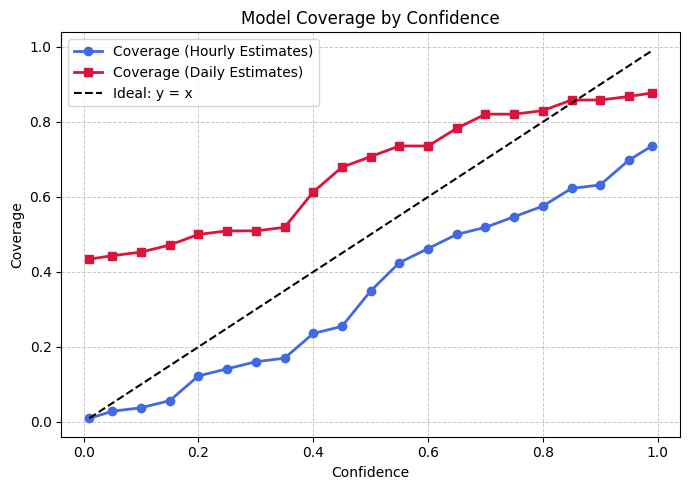

In [182]:
x = coverage_by_sens_df['sensitivity'].to_numpy()
y_hours = coverage_by_sens_df['coverage_hours'].to_numpy()
y_days = coverage_by_sens_df['coverage_days'].to_numpy()

plt.figure(figsize=(7, 5))

# Plot with improved styling
plt.plot(x, y_hours, color='royalblue', linestyle='-', marker='o',
         markersize=6, linewidth=2, label='Coverage (Hourly Estimates)')
plt.plot(x, y_days, color='crimson', linestyle='-', marker='s',
         markersize=6, linewidth=2, label='Coverage (Daily Estimates)')
plt.plot(x, x, color='black', linestyle='--', linewidth=1.5, label='Ideal: y = x')

# Titles and labels
plt.title('Model Coverage by Confidence')
plt.xlabel('Confidence')
plt.ylabel('Coverage')

# Axes formatting
plt.xticks()
plt.yticks()

#plt.xlim(0, 1.05)   # Confidence is between 0 and 1
#plt.ylim(0, 1.05)   # Coverage is a proportion

# Legend with frame
plt.legend(loc='best')

# Subtle grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()
plt.show()